In [1]:
import tensorflow.compat.v1 as tf
tf.enable_eager_execution()
from tensorflow import keras
import numpy as np
import random
import os
import gc
import time
import platform

from matplotlib import pyplot as plt

In [3]:
NUM_CLASSES = 10
WIDTH = 32
NUM_CHANNELS = 3
NUM_TRAIN = 50000
NUM_TEST = 10000
NUM_DEV = 100

DATASET = "cifar10"
BASE_DIR = f""

TRIAL = 1
MODEL_DIR = f"{BASE_DIR}/tmp/{DATASET}/original/{TRIAL}/model_ckpt_11.h5"

In [4]:
def _normalize(X):
  assert X.dtype == np.uint8
  X = X.astype(np.float64)
  X /= 255
  return X

def get_one_hot(targets, nb_classes):
  res = np.eye(nb_classes)[np.array(targets).reshape(-1)]
  return res.reshape(list(targets.shape)+[nb_classes])

def load_standard_cifar10():
  (X_train, Y_train), (X_validation, Y_validation) = tf.keras.datasets.cifar10.load_data()
  X_train = X_train.reshape(X_train.shape[0], WIDTH, WIDTH, NUM_CHANNELS)
  X_validation = X_validation.reshape(X_validation.shape[0], WIDTH, WIDTH, NUM_CHANNELS)

  X_train = _normalize(X_train)
  X_validation = _normalize(X_validation)

  Y_train = Y_train.astype(np.int32)
  Y_validation = Y_validation.astype(np.int32)

  return X_train, Y_train, X_validation, Y_validation

def load_cifar10_train_dev(num_dev=100):
  # randomly select and fixed for future (tracin-like strategy but their indices available only for mnist)
  # selected_dev = np.random.randint(0, X_validation.shape[0], num_dev)
  selected_dev = [5214, 2304, 5947, 9428, 2717, 8296, 7736, 8291, 5235, 54,
                  7499, 9590, 3675, 1932, 6646, 8719, 6484, 6306, 3066, 2442,
                  6106, 1949, 4320,  541, 1318, 5967, 2773, 3847, 1152, 9937,
                  7469, 5982, 7644, 5820, 8152, 9518,  601, 3953, 4931, 1924,
                  5342, 5467, 6718, 6779, 2860, 2440, 5480, 1178,  222, 7909,
                  6394, 3511, 8729, 6261, 7192, 9453, 5257, 9077, 6419, 3280,
                  3725, 3601, 8174, 5703, 4954, 9536, 4783, 2234, 7365, 2405,
                  3073, 2780, 7461, 3525, 7573, 6764, 9962, 7527,  992,  315,
                  6260, 9061,  592, 8003, 7594, 1930, 7215, 5124, 7531, 9471,
                  2824, 3533, 6062, 3946, 5246, 4440,  414, 3572, 4899, 884]
  X_train, Y_train, X_validation, Y_validation = load_standard_cifar10()
  X_dev = X_validation[selected_dev]
  Y_dev = Y_validation[selected_dev]
  return X_train, Y_train, X_dev, Y_dev

In [5]:
label_dict = {
    0: 'plane',  # 'airplane'; shortened for better plotting
    1: 'car',  # 'automobile'; shortened for better plotting
    2: 'bird',
    3: 'cat',
    4: 'deer',
    5: 'dog',
    6: 'frog',
    7: 'horse',
    8: 'ship',
    9: 'truck'
}

In [7]:
def plot_test_image(i, img, true_label, predictions_array):
  true_label, img = true_label[i], img[i].reshape(WIDTH, WIDTH, NUM_CHANNELS)
  predicted_label = predictions_array[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  plt.box(on=None)

  plt.imshow(img, cmap=plt.cm.binary)

  if predicted_label == true_label:
    color = 'tab:blue'
  else:
    color = 'tab:red'

  # plt.title("{0} ({1})".format(true_label, predicted_label),
  #                               color=color, fontsize=13)
  plt.title("{0}\n({1})".format(label_dict[true_label], label_dict[predicted_label]),
                                color=color, fontsize=13)


def plot_influence_image(i, img, true_label, influence, predicted_label):
  img = img.reshape(WIDTH, WIDTH, NUM_CHANNELS)
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  plt.box(on=None)

  plt.imshow(img, cmap=plt.cm.binary)
  if predicted_label == true_label:
    color = 'tab:blue'
  else:
    color = 'tab:red'
  # plt.title("{0} ({1})".format(true_label, predicted_label),
  #                               color=color, fontsize=13)
  plt.title("{0}\n({1})".format(label_dict[true_label], label_dict[predicted_label]),
                                color=color, fontsize=8)


def compare_methods(ex_id, X_train, Y_train, P_train, X_dev, Y_dev, P_dev, inf_list, names_list,
                    num_pos=5, num_neg=5, space_pos_neg=2, save_name=None):

  num_cols = 1+3+num_pos+space_pos_neg+num_neg
  num_train_examples = X_train.shape[0]
  num_rows = len(inf_list) + 1
  plt.figure(figsize=(num_cols, 1.3*num_rows))
  plt.subplot(num_rows, num_cols, 3*(num_cols)+1)  # position as per number of methods
  plot_test_image(ex_id, X_dev, Y_dev, P_dev)
  i = 1
  for (name, influences) in zip(names_list, inf_list):
    inf_values = rankings = np.flip(np.sort(influences[ex_id]))
    rankings = np.flip(np.argsort(influences[ex_id]))
    ax = plt.subplot(num_rows, num_cols, (num_cols)*i+3, xlabel=name)
    # ax.set_title(name)
    ax.set_title(name, x=1, y=0.3)  # aligning method with images
    ax.set_axis_off()

    # print(name)
    print(inf_values[:num_pos])
    for j in range(0,num_pos): # 5 most positive influential examples
      plt.subplot(num_rows, num_cols, (num_cols)*i+2+2+(j+1))
      influence_ex_id = rankings[j]
      plot_influence_image(influence_ex_id, X_train[influence_ex_id], Y_train[influence_ex_id], influences[i][influence_ex_id], P_train[influence_ex_id])
    if num_neg > 0:
      print(inf_values[-num_neg:], '\n')
    ### conditional selection for least similar in same and pred
    if ('same' in name.lower()) or ('baseline' in name.lower()):
      similarity = -1*influences[ex_id]
      y_pred = P_dev[ex_id]
      same_class = (Y_train==y_pred)
      similarity_cond = similarity[same_class]
      # Note that lowest distance means most similar
      most_similar_cond = np.sort(similarity_cond)
      least_similar_cond = most_similar_cond[::-1]
    ###
    for j in range(0,num_neg): # 5 most negative influential examples
      plt.subplot(num_rows, num_cols, (num_cols)*i+2+2+num_neg+1+(j+space_pos_neg))
      if ('same' in name.lower()) or ('baseline' in name.lower()):
        influence_ex_id = np.argmax(similarity == least_similar_cond[j])
      else:
        # so there opponent is really least ranked point (which is why they don't need to explicitly condition; we can suggest such explicit conditioning as well!)
        influence_ex_id = rankings[num_train_examples-(num_neg-j)]
      plot_influence_image(influence_ex_id, X_train[influence_ex_id], Y_train[influence_ex_id], influences[i][influence_ex_id], P_train[influence_ex_id])
    i += 1

  if save_name:
    plt.savefig(save_name, dpi=300, format='pdf', bbox_inches='tight', pad_inches=0)
  plt.show()

In [8]:
X_train, Y_train, X_dev, Y_dev = load_cifar10_train_dev()

170498071/170498071 [==============================] - 13s 0us/step


In [9]:
Y_train = np.squeeze(Y_train)
Y_dev = np.squeeze(Y_dev)

## Data Loading

In [10]:
pred_infl = np.load(BASE_DIR + '/pred_infl.npy', allow_pickle=True)

In [11]:
penult_infl = np.load(BASE_DIR + '/penult_infl.npy', allow_pickle=True)

In [13]:
trackin_influences = np.load(f"{BASE_DIR}/tmp/cifar10/original/1/trackin_precise_influences.npz")['arr_0']

In [14]:
representer_infl = np.load(BASE_DIR + '/tmp/cifar10/original/{0}/dev_representer_infl.npz'.format(TRIAL))['arr_0']

In [15]:
infl_fns = np.transpose(np.load(BASE_DIR + '/tmp/cifar10/original/{0}/dev_influences_inf_fun.npz'.format(TRIAL))['arr_0'])

## Visualization

In [16]:
model = tf.keras.models.load_model(MODEL_DIR)

P_train = np.argmax(model.predict(np.squeeze(X_train)), axis=1)
P_dev = np.argmax(model.predict(np.squeeze(X_dev)), axis=1)

4/4 [==============================] - 0s 102ms/step


[-0.00016263 -0.00019405 -0.00019786 -0.00020138 -0.00020147]
[-5.43135694 -6.55270584 -6.59822782 -6.61265157 -6.67618354]
[0.02204096 0.02200941 0.02059997 0.02017726 0.01917442]
[248.28162 241.4592  233.84253 217.06451 216.71341]
[199.84627  111.32992   97.921074  93.57061   92.7802  ]


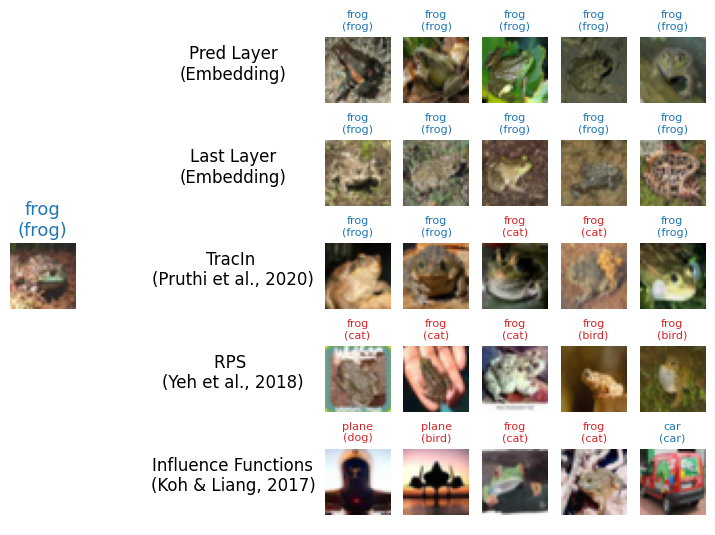

[-0.03193329 -0.0399524  -0.04209684 -0.04378321 -0.04475059]
[-10.6945431  -11.65329102 -11.7128357  -11.76885193 -11.83243405]
[0.26569074 0.24579262 0.20351456 0.17496592 0.17269077]
[301.12656 267.29254 257.10577 254.09608 231.5151 ]
[244.85    217.37064 215.57608 210.2714  199.30753]


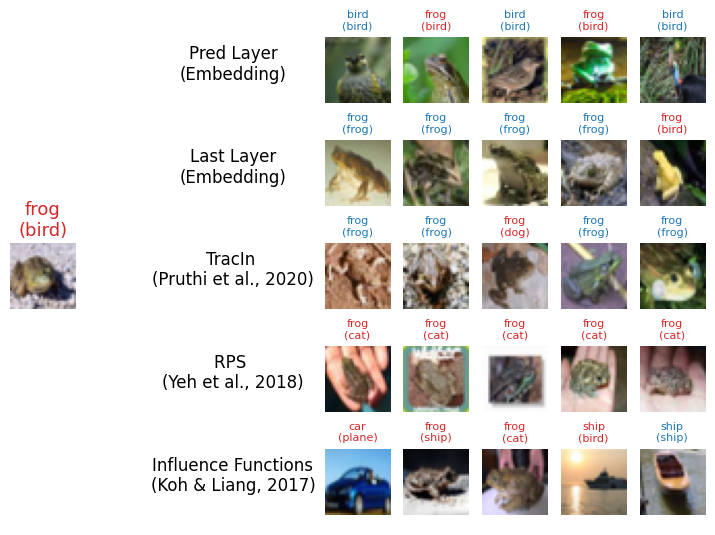

[-5.28374050e-07 -5.71640565e-07 -6.64985666e-07 -7.20191965e-07
 -7.41101752e-07]
[-10.14232228 -10.9022844  -11.0629044  -11.4772467  -11.52070886]
[0.76692219 0.66854481 0.66751905 0.58518087 0.49436912]
[392.8567  388.257   356.4334  329.82254 319.2025 ]
[469.0954  400.75397 313.1406  285.36288 282.39096]


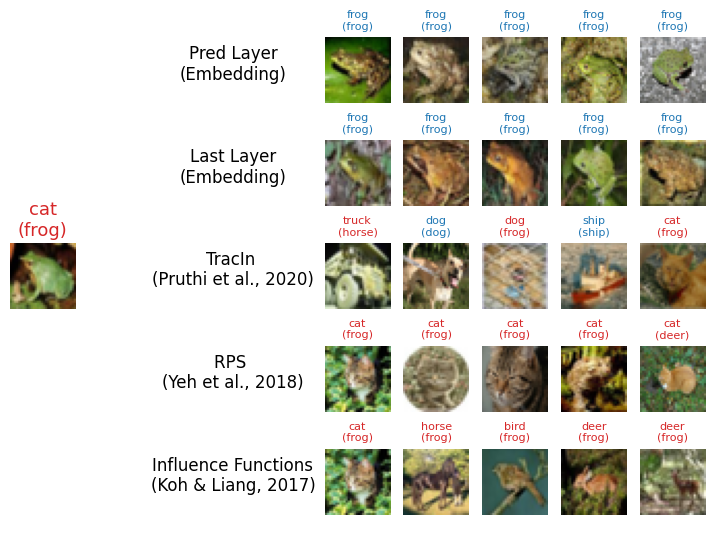

In [ ]:
import matplotlib
matplotlib.rcParams["figure.dpi"] = 100

n_dev = len(Y_dev)
for ex_id in [1, 77, 69]:
  compare_methods(ex_id, X_train, Y_train, P_train, X_dev, Y_dev, P_dev,
                  [pred_infl, penult_infl, trackin_influences, representer_infl, infl_fns],
                  ['Pred Layer\n(Embedding)', 'Last Layer\n(Embedding)', 'TracIn \n(Pruthi et al., 2020)', 'RPS \n(Yeh et al., 2018)', 'Influence Functions\n(Koh & Liang, 2017)'],
                  num_pos=5, num_neg=0, save_name=f"{BASE_DIR}/sota_cifar10_{ex_id}_ms_aistats")

[-0.03203193 -0.03776054 -0.04150296 -0.04776277 -0.04885195]
[-7.92749066 -7.9365706  -8.36988673 -8.391958   -8.43400527]
[0.17399519 0.13974296 0.13231629 0.12755704 0.1126624 ]
[436.49384 421.5349  420.81415 383.35052 381.18347]
[312.71814 250.48778 212.65842 188.9124  179.721  ]


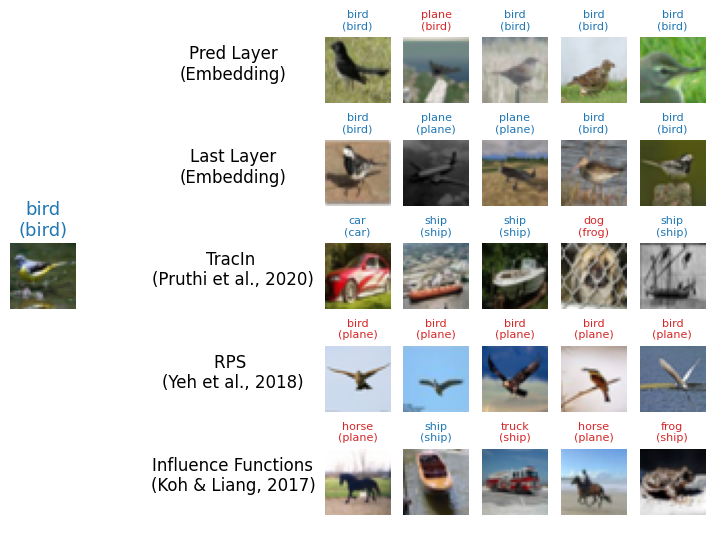

[-0.08427328 -0.08445531 -0.10419851 -0.10564946 -0.10643082]
[-6.13706077 -6.43853579 -6.47205105 -6.73525211 -6.82220499]
[0.2712541  0.23547625 0.22677686 0.21967678 0.1950072 ]
[204.7515  184.06978 147.54573 146.04811 145.86324]
[149.37483 142.10568 123.43119 122.86143 121.20201]


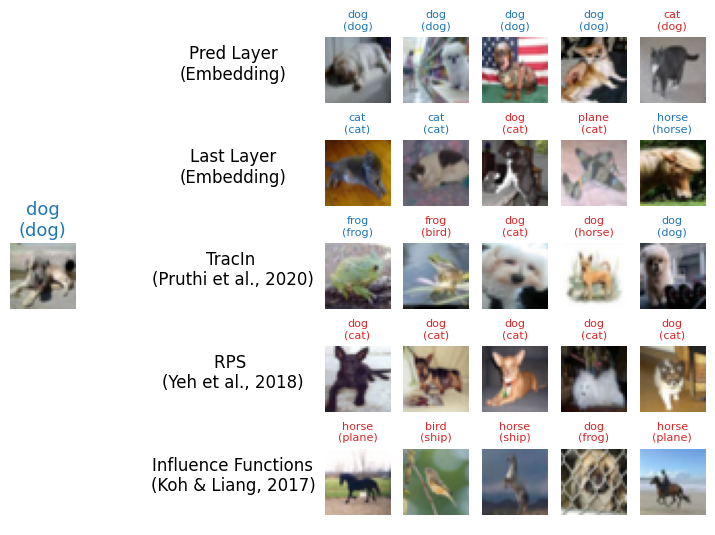

[-0.00176801 -0.00298355 -0.00317141 -0.00324383 -0.0034665 ]
[-8.56851416 -8.7228918  -8.8795082  -8.9798063  -9.29611723]
[0.51177906 0.42625276 0.34414308 0.34367342 0.27671786]
[343.21143 286.726   282.29745 263.94305 227.98976]
[140.13338  112.06899  102.762215  93.50296   92.37589 ]


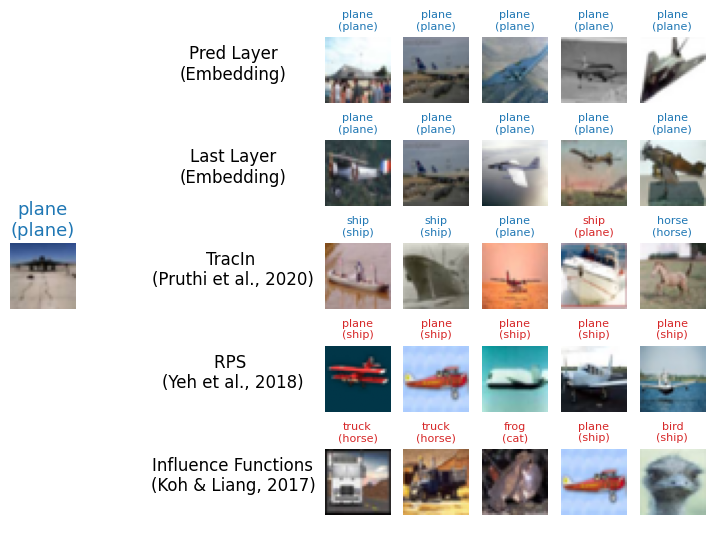

[-2.05825875e-05 -2.28459831e-05 -2.42089228e-05 -2.48881665e-05
 -2.56875545e-05]
[-11.19173291 -11.60298209 -12.17669394 -12.48723252 -12.65603953]
[0.20064617 0.19288129 0.18934163 0.13938557 0.13064871]
[398.63632 379.99585 370.69183 321.53616 320.5309 ]
[136.9546  126.23324 105.93146 104.24627 103.45154]


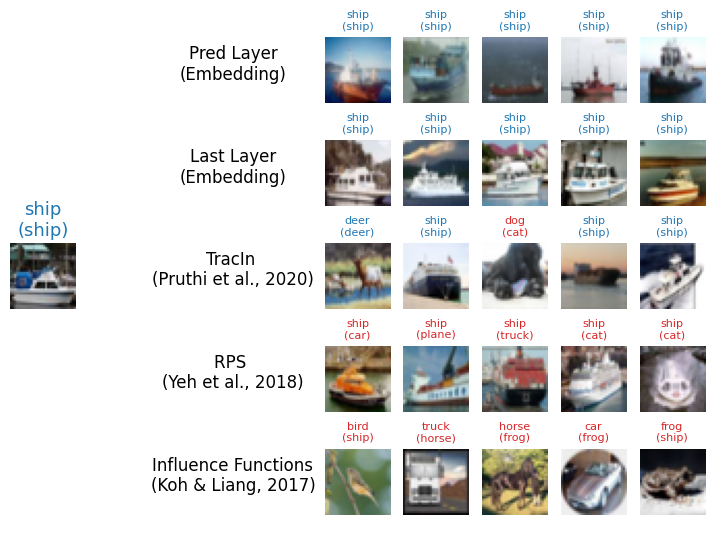

[-0.0024944  -0.00428938 -0.00461586 -0.00538502 -0.00562216]
[-5.81757097 -5.82909108 -5.83171206 -5.83579903 -6.05031251]
[0.1997395  0.19591317 0.15817919 0.14512848 0.14166635]
[134.66943  121.77064  113.98565  108.458916 107.943   ]
[113.42887 105.72102 102.69506  83.44537  79.31484]


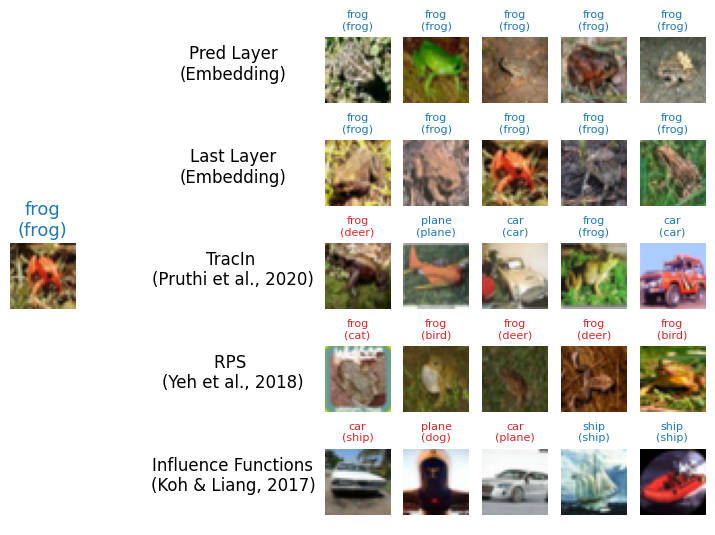

[-0.00517697 -0.00782185 -0.00881402 -0.00975417 -0.01053511]
[ -9.56648327 -10.41306874 -10.42277315 -10.65234709 -10.94600973]
[0.10040594 0.08086762 0.06707561 0.06412883 0.06329448]
[628.60126 565.32275 547.23157 493.2747  485.49277]
[187.60374 140.32458 111.55785 110.52467 104.39933]


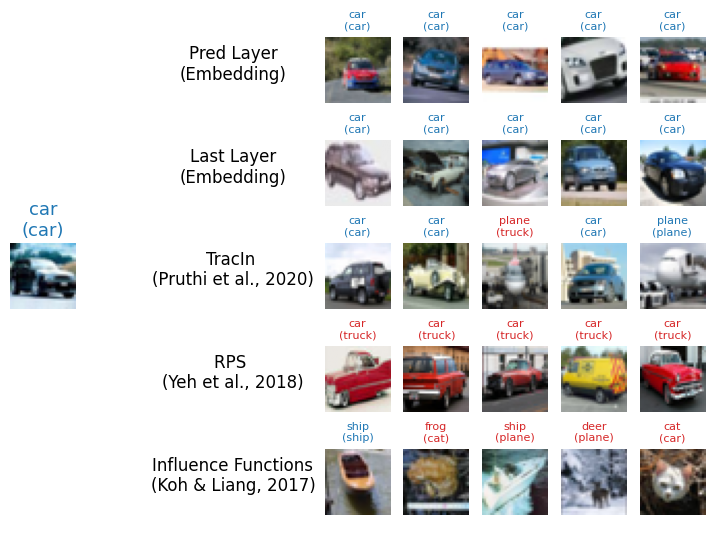

[-0.00083779 -0.00138617 -0.00186315 -0.00191585 -0.00199804]
[-7.66804549 -7.96439156 -7.99317751 -8.0506573  -8.17363656]
[0.09895409 0.09823169 0.08928324 0.07543691 0.07268004]
[387.75723 380.8871  356.16156 348.77344 333.98322]
[119.29359  117.814     93.48488   85.1856    84.323715]


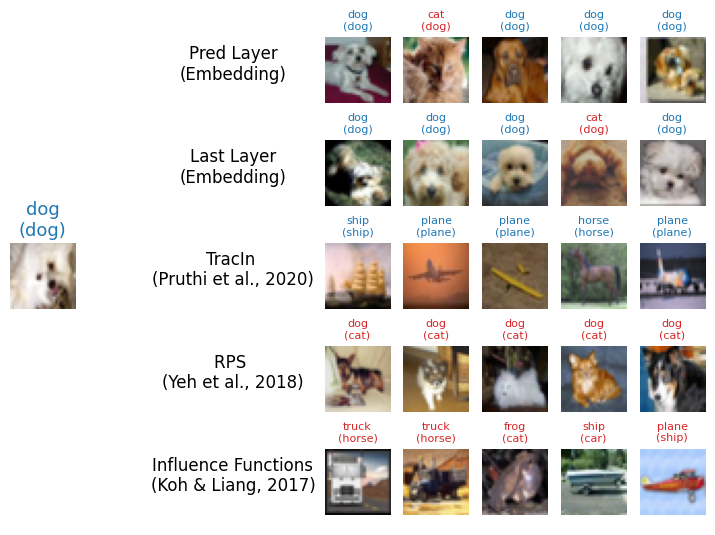

[-0.0006759  -0.00070143 -0.00074596 -0.00077468 -0.00084278]
[-8.77887992 -8.80865466 -9.00146483 -9.52641911 -9.68553733]
[0.13701463 0.12907938 0.1253315  0.12354994 0.11764073]
[495.80066 462.59213 436.68753 410.4831  393.30283]
[157.36783  125.012436 111.373245 107.20735   95.88399 ]


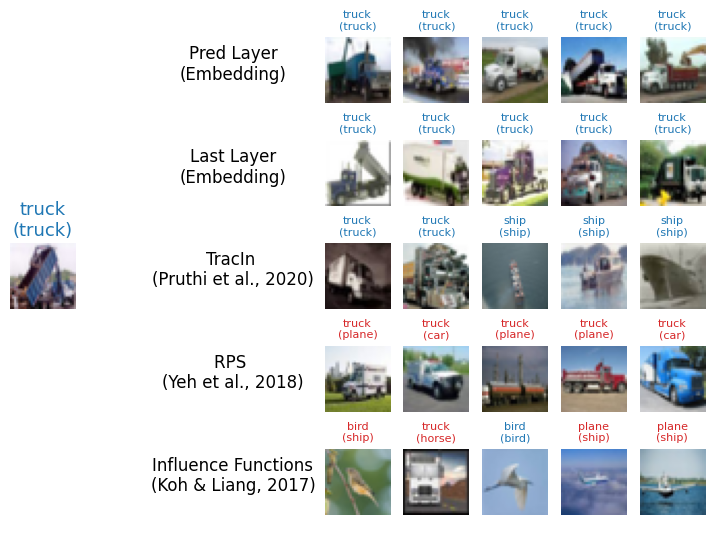

[-0.01837097 -0.01846648 -0.01856349 -0.01914477 -0.01954888]
[-8.97499152 -9.02532688 -9.17535704 -9.20633476 -9.28570271]
[0.25710977 0.20539437 0.18592209 0.14634017 0.1424971 ]
[400.40732 393.77258 389.66306 369.5291  361.76416]
[193.17328 127.24453 116.72953 113.20825 112.25433]


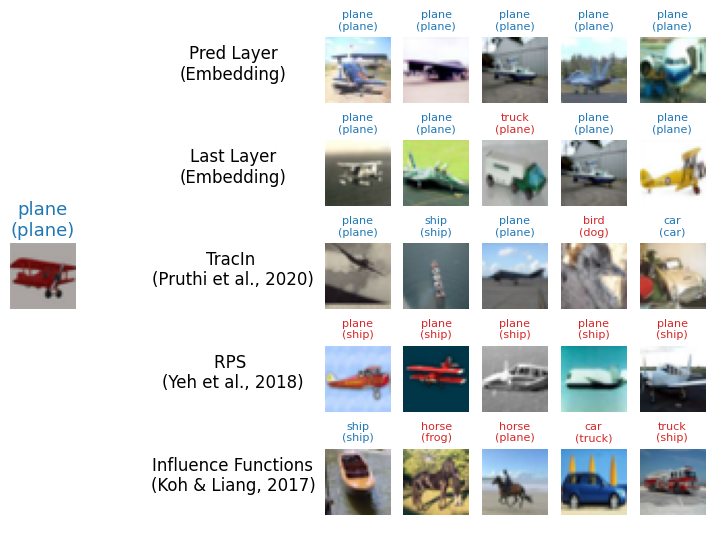

[-0.02548898 -0.03321987 -0.03492787 -0.03554458 -0.03578342]
[-6.7830675  -7.12349036 -7.29973477 -7.50588313 -7.60121312]
[0.1668909  0.16535706 0.14807372 0.14637249 0.1310562 ]
[263.8756  247.77087 241.96895 228.873   225.6934 ]
[169.0647  122.26888 115.33557 107.38268 102.83148]


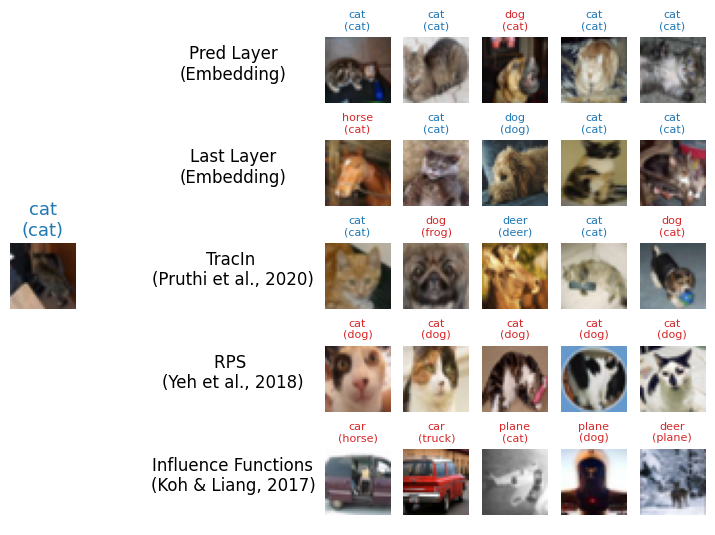

In [17]:
n_dev = len(Y_dev)
for ex_id in np.random.choice(n_dev, int(0.1*n_dev), replace=False):
  compare_methods(ex_id, X_train, Y_train, P_train, X_dev, Y_dev, P_dev,
                  [pred_infl, penult_infl, trackin_influences, representer_infl, infl_fns],
                  ['Pred Layer\n(Embedding)', 'Last Layer\n(Embedding)', 'TracIn \n(Pruthi et al., 2020)', 'RPS \n(Yeh et al., 2018)', 'Influence Functions\n(Koh & Liang, 2017)'],
                  num_pos=5, num_neg=0)